# Feature selection

In this example we will see how to **select features** through **sequential selection**.

As a toy example, we will use data from 'Titanic: Machine Learning for Disaster', one of the most popular Kaggle competitions. However, we will not use the original data set. We will use a modified data set, which results from a [Kaggle kernel](https://www.kaggle.com/pmarcelino/data-analysis-and-feature-extraction-with-python) that I did. 

[Here](https://github.com/pmarcelino/blog/data/titanic_modified.csv) you can access to the data set used in this exercise.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

%matplotlib inline

# Load data

Let's load the data set.

In [2]:
df = pd.read_csv('data/titanic_modified.csv', index_col=0)
df.head()

,Survived,Fare,FamilySize,Imputed,Pclass_2,Pclass_3,Sex_male,Age_Child,Age_Elder,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,7.2500,1,0,0,1,1,0,0,0,1,0,1,0,0
1,1,71.2833,1,0,0,0,0,0,0,0,0,0,0,1,0
2,1,7.9250,0,0,0,1,0,0,0,0,1,1,0,0,0
3,1,53.1000,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0,8.0500,0,0,0,1,1,0,0,0,1,0,1,0,0


As I mentioned, this data set results from a [kernel](https://www.kaggle.com/pmarcelino/data-analysis-and-feature-extraction-with-python) that I already did for the Titanic competition. I'll summarize each of the features to give you some context:

* **Survived**. Target variable. It's 1 if the passenger survived and 0 if it didn't.
* **Fare**. Passenger fare. It keeps the same properties as the original feature.
* **FamilySize**. It's the sum of the original features SipSp and Parch. SipSp refers to the # of siblings / spouses aboard the Titanic. Parch refers to the # of parents / children aboard the Titanic.
* **Imputed**. Identifies instances where some missing data imputation was made.
* **Pclass**. Ticket class. The feature was [encoded](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features), so we just have the features corresponding to the second and third class. The one corresponding to the first class was deleted to avoid the [dummy trap](http://www.algosome.com/articles/dummy-variable-trap-regression.html).
* **Sex**. It was also encoded. It's 1 if the instance corresponds to a male, and 0 if it corresponds to a female.
* **Age**. Encoded to the following classes: Children, Adult, and Elder. It's an Adult if Age_Child = 0 and Age_Elder = 0.
* **Embarked**. Port of embarkation. Originally, we had three possible ports: C = Cherbourg, Q = Queenstown, S = Southampton.
* **Title**. Results from the name of the passenger. Guess what? It's also an encoded feature.

# Train and test data sets

In feature selection, our goal is to distinguish features that are useful for prediction from features that just add noise to the prediction model.

To test the model's performance on unseen data, we need a train and a test data set.

In [3]:
# Create train and test set
from sklearn.model_selection import train_test_split

X = df.drop('Survived', axis=1)  # Keep all features except 'Survived'
y = df['Survived']  # Just keep 'Survived'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

# Feature selection

The solution we propose uses [mlxtend](http://rasbt.github.io/mlxtend/). Mlxtend is a Python library of useful tools for the day-to-day data science tasks. It was written by [Sebastian Raschka](https://sebastianraschka.com/), one of the data scientists that I follow.

Sequential feature selection recursively removes or adds features based on the classifier performance. The recursion proceeds until we reach a feature subset of the desired size. We say that the recursion works 'backward' if we remove features, and we say that the recursion works 'forward' if we add features.

For example, let's consider that we have 14 features and we want to reduce the feature subset to 10 features. Assume that we want to use sequential forward selection. In this case, we will start without features and, step by step, we will add one feature to the subset. This feature will be the one that brings the greatest increase to the classifier performance. We keep adding features until our feature subset has 10 features. 

Sequential backward selection works in the opposite way. We start with all features and, step by step, we remove the feature that least influences the classifier performance.

In addition to the 'backward' and 'forward', mlxtend has a 'floating' option. Floating allow us to have an additional exclusion or inclusion step to remove features once they were included (or excluded). This step is conditional and only occurs if the resulting feature subset is assessed as "better" by the criterion function after removal (or addition) of a particular feature. Floating allow us to consider a wider range of combinations, which can provide us better results.

Mlxtend offers four different ways to perform sequential feature selection:

* Sequential forward selection.
* Sequential backward selection.
* Sequential forward floating selection.
* Sequential backward floating selection.

In this example we will test all of them.

In [4]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
max_features = np.shape(X_train)[1]

* Here we define the base classifier *lr* that will be used to solve the problem. Logistic regression was chosen to make this notebook coherent with previous notebooks ([x](), [x]()).
* *max_features* is the number of features that we want to select.

In [5]:
# Sequential forward selection
sfs = SFS(lr,
          k_features = (1,max_features), # Select the best feature combination in the range 1 to max_features
          forward = True,
          floating = False,
          scoring = 'accuracy',
          cv = 10,  # Performs stratified k-fold by default.
          n_jobs = -1)
sfs = sfs.fit(X_train.values, y_train) # Use .values because the method can't read DataFrame data structures.

print('Sequential forward selection (%i features): ' % np.size(sfs.k_feature_idx_))
print(sfs.k_feature_idx_)
print('CV score: ')
print(sfs.k_score_)

Sequential forward selection (12 features): 
(0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13)
CV score: 
0.8385295103957077


* We create a sequential feature selection structure *SFS* that uses *lr* as an estimator, has *7 features*, does *forward* selection, *excludes* the conditional floating option, uses *accuracy* as the performance metrics, performs *cross-validation*, and uses all CPUs to evaluate the different subsests (n_jobs = -1).
* We perform feature selection and learn the model using the training data.
* We print the selected features and the performance score.

In [6]:
# Sequential backward selection
sbs = SFS(lr, 
          k_features = (1,max_features),
          forward = False, 
          floating = False, 
          scoring = 'accuracy',
          cv = 10, 
          n_jobs = -1)
sbs = sbs.fit(X_train.values, y_train)

print('Sequential backward selection (%i features): ' % np.size(sbs.k_feature_idx_))
print(sbs.k_feature_idx_)
print('CV score: ')
print(sbs.k_score_)

Sequential backward selection (4 features): 
(0, 1, 11, 13)
CV score: 
0.8455130784708249


* In this case we perform a backward selection, so we define that *forward = False*. Everything else remains equal.

In [7]:
# Sequential forward floating selection
sffs = SFS(lr, 
           k_features = (1,max_features), 
           forward = True, 
           floating = True, 
           scoring = 'accuracy', 
           cv = 10, 
           n_jobs = -1)
sffs = sffs.fit(X_train.values, y_train)

print('Sequential forward floating selection (%i features): ' % np.size(sffs.k_feature_idx_))
print(sffs.k_feature_idx_)
print('CV score: ')
print(sffs.k_score_)

Sequential forward floating selection (10 features): 
(1, 2, 3, 4, 6, 8, 9, 11, 12, 13)
CV score: 
0.8483501006036217


* The main difference here is that we activate the *floating* option.

In [8]:
# Sequential backward floating selection
sbfs = SFS(lr, 
           k_features = (1,max_features), 
           forward = False,
           floating = True,
           scoring = 'accuracy', 
           cv = 10, 
           n_jobs = -1)
sbfs = sbfs.fit(X_train.values, y_train)

print('Sequential backward floating selection (%i features): ' % np.size(sbfs.k_feature_idx_))
print(sbfs.k_feature_idx_)
print('CV score: ')
print(sbfs.k_score_)

Sequential backward floating selection (10 features): 
(1, 2, 3, 4, 6, 8, 9, 11, 12, 13)
CV score: 
0.8483501006036217


As we can see, the classifier performs better when we use backward or forward floating selection.

Let's visualize the results of the best performing solution in DataFrames and plots.

### Visualize results with DataFrames

In [9]:
# Sequential forward floating selection (dataframe)
pd.DataFrame.from_dict(sffs.get_metric_dict()).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
1,0.801928,0.0347337,"[0.7916666666666666, 0.7361111111111112, 0.875...","(5,)",0.046766,0.0155887
2,0.806153,0.0328688,"[0.7916666666666666, 0.7361111111111112, 0.875...","(1, 5)",0.0442551,0.0147517
3,0.810359,0.0313243,"[0.7777777777777778, 0.75, 0.8888888888888888,...","(1, 4, 5)",0.0421755,0.0140585
4,0.82865,0.03601,"[0.7777777777777778, 0.7777777777777778, 0.888...","(1, 4, 5, 6)",0.0484845,0.0161615
5,0.831486,0.039996,"[0.7638888888888888, 0.7777777777777778, 0.888...","(1, 4, 5, 6, 12)",0.0538512,0.0179504
6,0.832875,0.038803,"[0.7777777777777778, 0.7777777777777778, 0.888...","(1, 2, 4, 5, 6, 12)",0.052245,0.017415
7,0.832915,0.0392131,"[0.7777777777777778, 0.7638888888888888, 0.888...","(1, 2, 4, 5, 6, 8, 12)",0.0527972,0.0175991
8,0.832915,0.0392131,"[0.7777777777777778, 0.7638888888888888, 0.888...","(1, 2, 4, 5, 6, 7, 8, 12)",0.0527972,0.0175991
9,0.832915,0.0397522,"[0.7916666666666666, 0.75, 0.8888888888888888,...","(1, 2, 4, 5, 6, 7, 8, 9, 12)",0.0535229,0.017841
10,0.84835,0.0321055,"[0.8194444444444444, 0.7916666666666666, 0.888...","(1, 2, 3, 4, 6, 8, 9, 11, 12, 13)",0.0432273,0.0144091


### Visualize results with plots

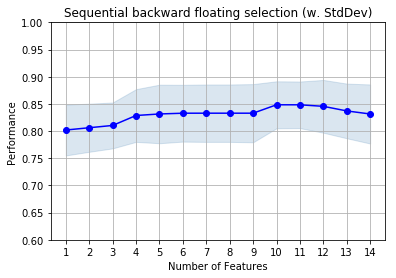

In [10]:
# Sequential forward floating selection (plot)
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.ylim([0.6,1])
plt.title('Sequential backward floating selection (w. StdDev)')
plt.grid()
plt.show()

# Conclusion

In this example we applied sequential feature selection. This technique recursively adds (or removes) features to the feature subset based on classifier's performance. 

The best performing cases were the ones considering the 'floating' option. This is true for both backward and forward methods. Comparing the results with other solutions ([univariate feature selection]() and [model-based selection]()), we can say that sequential feature selection is the best perfoming solution.

# Complete solution

To conclude, we will define a complete solution that automatically chooses the best performing model.

Sequential forward selection (12 features): 
(0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13)
CV score: 
0.8385295103957077
Sequential backward selection (4 features): 
(0, 1, 11, 13)
CV score: 
0.8455130784708249
Sequential forward floating selection (10 features): 
(1, 2, 3, 4, 6, 8, 9, 11, 12, 13)
CV score: 
0.8483501006036217
Sequential backward floating selection (10 features): 
(1, 2, 3, 4, 6, 8, 9, 11, 12, 13)
CV score: 
0.8483501006036217
Best model: SequentialFeatureSelector(clone_estimator=True, cv=10,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             floating=True, forward=False, k_features=(1, 14), n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='accuracy', verbose=0)


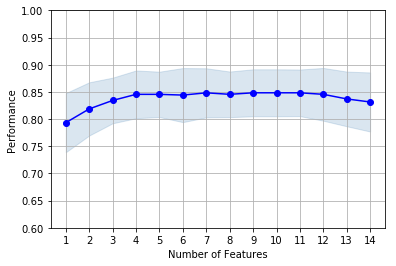

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

# Load data
df = pd.read_csv('data/titanic_modified.csv', index_col=0)
df.head()

# Create train and test set
X = df.drop('Survived', axis=1)  # Keep all features except 'Survived'
y = df['Survived']  # Just keep 'Survived'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

# Create classifier
lr = LogisticRegression()

# Start variables
max_features = np.shape(X_train)[1]
best_score = 0
best_model = ''

# Sequential forward selection
sfs = SFS(lr,
          k_features = (1,max_features), # Select the best feature combination in the range 1 to max_features
          forward = True,
          floating = False,
          scoring = 'accuracy',
          cv = 10,  # Performs stratified k-fold by default.
          n_jobs = -1)
sfs = sfs.fit(X_train.values, y_train) # Use .values because the method can't read DataFrame data structures.

if sfs.k_score_ > best_score:  # To select the best model and visualize the results (DataFrame and plot)
    best_model = sfs
    
print('Sequential forward selection (%i features): ' % np.size(sfs.k_feature_idx_))
print(sfs.k_feature_idx_)
print('CV score: ')
print(sfs.k_score_)

# Sequential backward selection
sbs = SFS(lr, 
          k_features = (1,max_features),
          forward = False, 
          floating = False, 
          scoring = 'accuracy',
          cv = 10, 
          n_jobs = -1)
sbs = sbs.fit(X_train.values, y_train)

if sbs.k_score_ > best_score:
    best_model = sbs

print('Sequential backward selection (%i features): ' % np.size(sbs.k_feature_idx_))
print(sbs.k_feature_idx_)
print('CV score: ')
print(sbs.k_score_)

# Sequential forward floating selection
sffs = SFS(lr, 
           k_features = (1,max_features), 
           forward = True, 
           floating = True, 
           scoring = 'accuracy', 
           cv = 10, 
           n_jobs = -1)
sffs = sffs.fit(X_train.values, y_train)

if sffs.k_score_ > best_score:
    best_model = sffs

print('Sequential forward floating selection (%i features): ' % np.size(sffs.k_feature_idx_))
print(sffs.k_feature_idx_)
print('CV score: ')
print(sffs.k_score_)

# Sequential backward floating selection
sbfs = SFS(lr, 
           k_features = (1,max_features), 
           forward = False,
           floating = True,
           scoring = 'accuracy', 
           cv = 10, 
           n_jobs = -1)
sbfs = sbfs.fit(X_train.values, y_train)

if sbfs.k_score_ > best_score:
    best_model = sbfs

print('Sequential backward floating selection (%i features): ' % np.size(sbfs.k_feature_idx_))
print(sbfs.k_feature_idx_)
print('CV score: ')
print(sbfs.k_score_)

# Visualize results
print('Best model: %s' % best_model)
## Sequential forward floating selection (dataframe)
pd.DataFrame.from_dict(best_model.get_metric_dict()).T

## Sequential forward floating selection (plot)
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(best_model.get_metric_dict(), kind='std_dev')
plt.ylim([0.6,1])
plt.grid()
plt.show()